### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

### Exploratory Data Analysis (EDA)
   * Concatenating training and testing data for easier preprocessing.
   * Statistical summary of data.
   * Analysing missing value rates.
   * Handling missing values.
   * Visualizing features.
   * Encode categorical features like sex, embarked, etc.
   * Applying log-transformation to normalize the features and git rid of the skew.
   * Using Min-Max to scale the features.
   * Handling outliers.
   * Separating the test data.

In [2]:
# Loading dataset
train_set = pd.read_csv("titanic.csv")
print("Number of rows in train set:", train_set.shape[0])
test_set = pd.read_csv("test.csv")
test_set.rename(columns={'sibSp': 'sibsp'}, inplace=True) # Fixing feature name to avoid duplication.
print("Number of rows in test set:", test_set.shape[0])

# Concatenating the train and test data
df = pd.concat([train_set, test_set], ignore_index=True)
df["survived"] = df["survived"].fillna(0)
df.tail().style.background_gradient(cmap="turbo")

Number of rows in train set: 1309
Number of rows in test set: 19


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
1323,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance Toogood)",female,47.000000,1,0,W.E.P. 5734,61.175000,E31,S,0.000000
1324,2,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.000000,1,0,SC/PARIS 2167,27.720800,nan,C,0.000000
1325,2,"Keane, Mr. Daniel",male,35.000000,0,0,233734,12.350000,nan,Q,0.000000
1326,3,"Assaf, Mr. Gerios",male,21.000000,0,0,2692,7.225000,nan,C,0.000000
1327,3,"Ilmakangas, Miss. Ida Livija",female,27.000000,1,0,STON/O2. 3101270,7.925000,nan,S,0.000000


In [3]:
# Statistical summary
df.describe().T.style.background_gradient(cmap="turbo")

,count,mean,std,min,25%,50%,75%,max
pclass,1328.000000,2.296687,0.836753,1.000000,2.000000,3.000000,3.000000,3.000000
age,1064.000000,29.927788,14.413728,0.166700,21.000000,28.000000,39.000000,80.000000
sibsp,1328.000000,0.499247,1.036631,0.000000,0.000000,0.000000,1.000000,8.000000
parch,1328.000000,0.381024,0.860768,0.000000,0.000000,0.000000,0.000000,9.000000
fare,1327.000000,33.106063,51.464510,0.000000,7.895800,14.454200,31.137500,512.329200
survived,1328.000000,0.376506,0.484692,0.000000,0.000000,0.000000,1.000000,1.000000


In [4]:
# Analysing missing value rates
for col in df.columns:
    print(f"{col} missing value rate: {round(df[col].isnull().sum() * 100 / len(df),2)}%")

pclass missing value rate: 0.0%
name missing value rate: 0.0%
sex missing value rate: 0.0%
age missing value rate: 19.88%
sibsp missing value rate: 0.0%
parch missing value rate: 0.0%
ticket missing value rate: 0.0%
fare missing value rate: 0.08%
cabin missing value rate: 77.64%
embarked missing value rate: 0.15%
survived missing value rate: 0.0%


### Findings based on analysis
   * Four columns have missing data: age, fare, cabin, embarked
      * We can handel the "fare" and "embarked columns by dropping the rows with missing value since they represent less than 1% of our data.
      * For the "cabin" column, more than 75% of the values are missing. So, there is really nothing we can do for that column but drop it.
      * As for the "age" column, we measured the models' performance with it and without it, and the results have shown improvement when using the "age" column even though we lose 20% of our training data.

In [5]:
# Handling missing values
# Drop columns with high missing-value rates
df.drop(columns=["cabin"], inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

print("Number of rows:", df.shape[0])

Number of rows: 1061


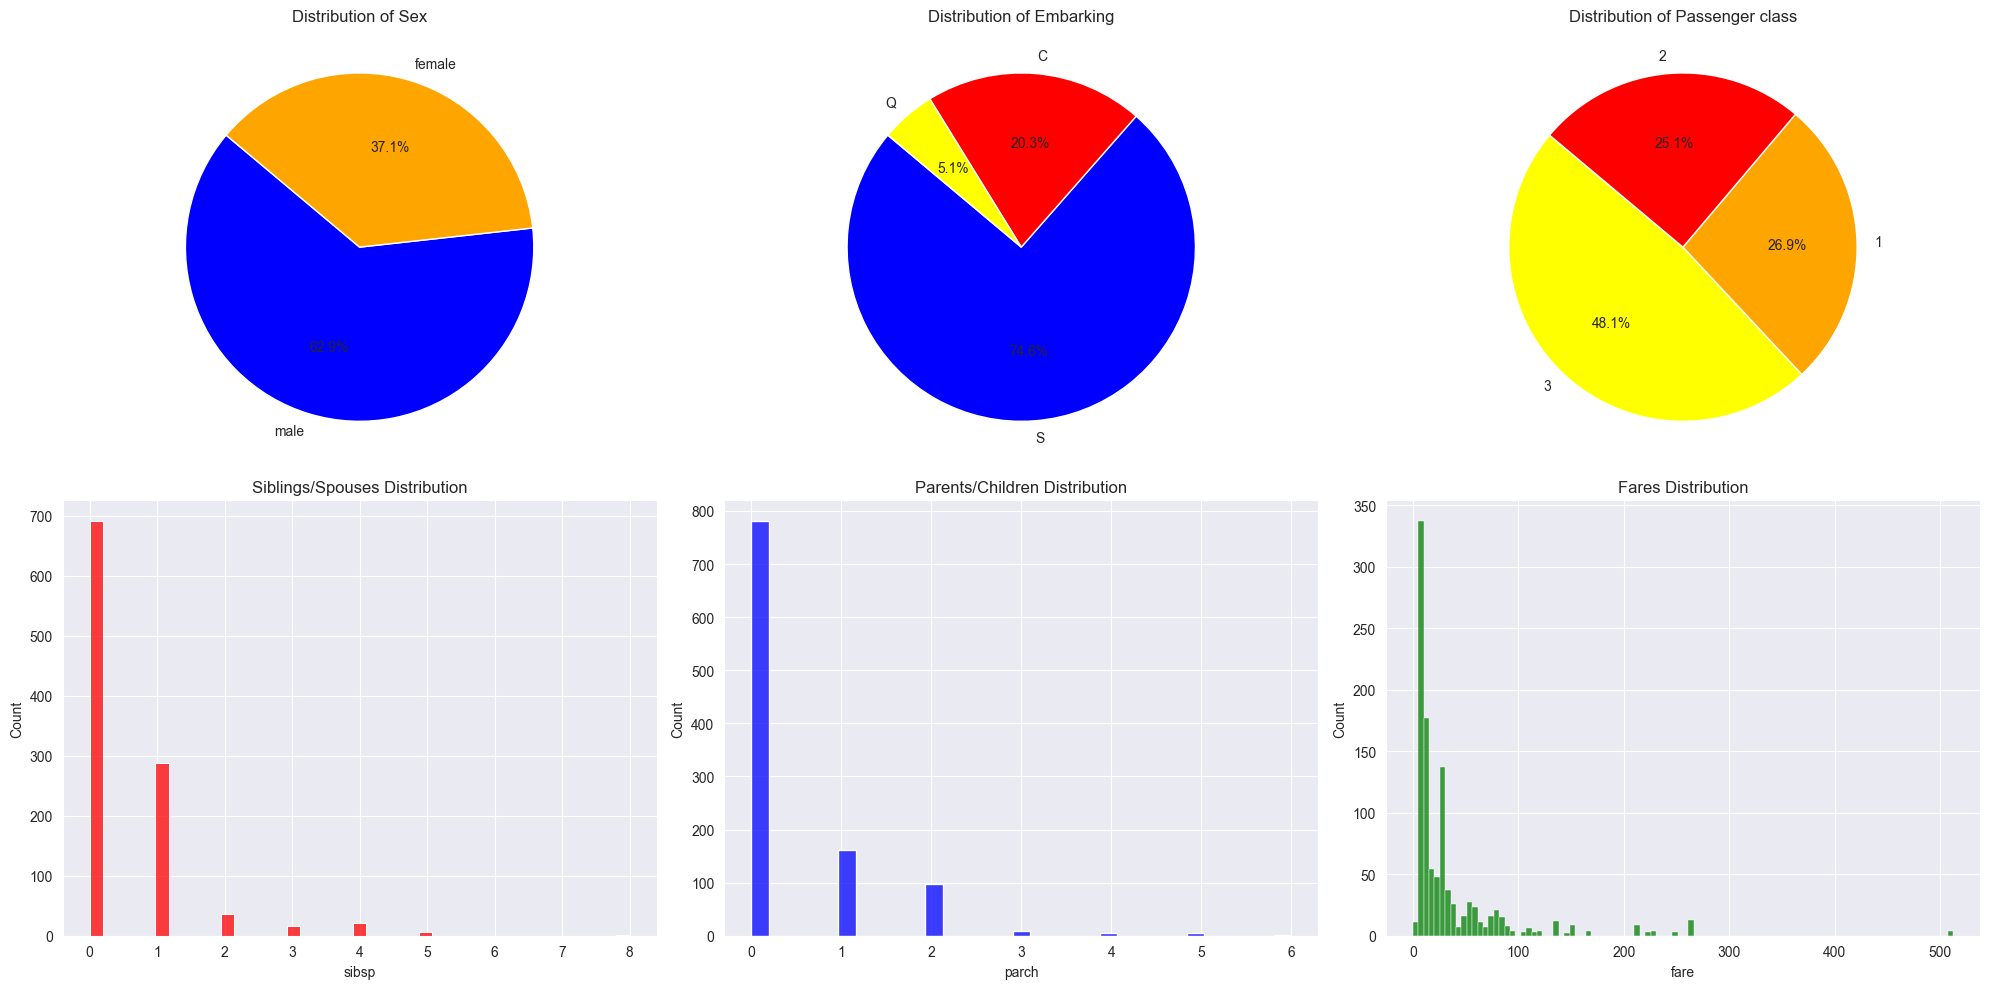

In [6]:
# Visualizing features
axes = plt.subplots(2, 3, figsize=(20, 10))[1]

# Sex Distribution
sex_counts = df['sex'].value_counts(normalize=True)
axes[0, 0].pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'orange'])
axes[0, 0].set_title('Distribution of Sex')

# Embarked Distribution
embarked_counts = df['embarked'].value_counts(normalize=True)
axes[0, 1].pie(embarked_counts, labels=embarked_counts.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'red', 'yellow'])
axes[0, 1].set_title('Distribution of Embarking')

# Passenger class Distribution
pclass_counts = df['pclass'].value_counts(normalize=True)
axes[0, 2].pie(pclass_counts, labels=pclass_counts.index, autopct='%1.1f%%', startangle=140, colors=['yellow', 'orange', 'red'])
axes[0, 2].set_title('Distribution of Passenger class')

# Siblings/Spouses Distribution
sns.histplot(df['sibsp'], ax=axes[1, 0], color='red')
axes[1, 0].set_title('Siblings/Spouses Distribution')

# Parents/Children Distribution
sns.histplot(df['parch'], ax=axes[1, 1], color='blue')
axes[1, 1].set_title('Parents/Children Distribution')

# Fares Distribution
sns.histplot(df['fare'], ax=axes[1, 2], color='green')
axes[1, 2].set_title('Fares Distribution')

plt.tight_layout()
plt.show()

In [7]:
# Encoding categorical features
df = pd.concat([df, pd.get_dummies(df['sex'], prefix='sex')], axis=1)
df.drop('sex', axis=1, inplace=True)
df = pd.concat([df, pd.get_dummies(df['embarked'], prefix='embarked')], axis=1)
df.drop('embarked', axis=1, inplace=True)

df.head().style.background_gradient(cmap="turbo")

,pclass,name,age,sibsp,parch,ticket,fare,survived,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,"Allen, Miss. Elisabeth Walton",29.000000,0,0,24160,211.337500,1.000000,True,False,False,False,True
1,1,"Allison, Master. Hudson Trevor",0.916700,1,2,113781,151.550000,1.000000,False,True,False,False,True
2,1,"Allison, Miss. Helen Loraine",2.000000,1,2,113781,151.550000,0.000000,True,False,False,False,True
3,1,"Allison, Mr. Hudson Joshua Creighton",30.000000,1,2,113781,151.550000,0.000000,False,True,False,False,True
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.000000,1,2,113781,151.550000,0.000000,True,False,False,False,True


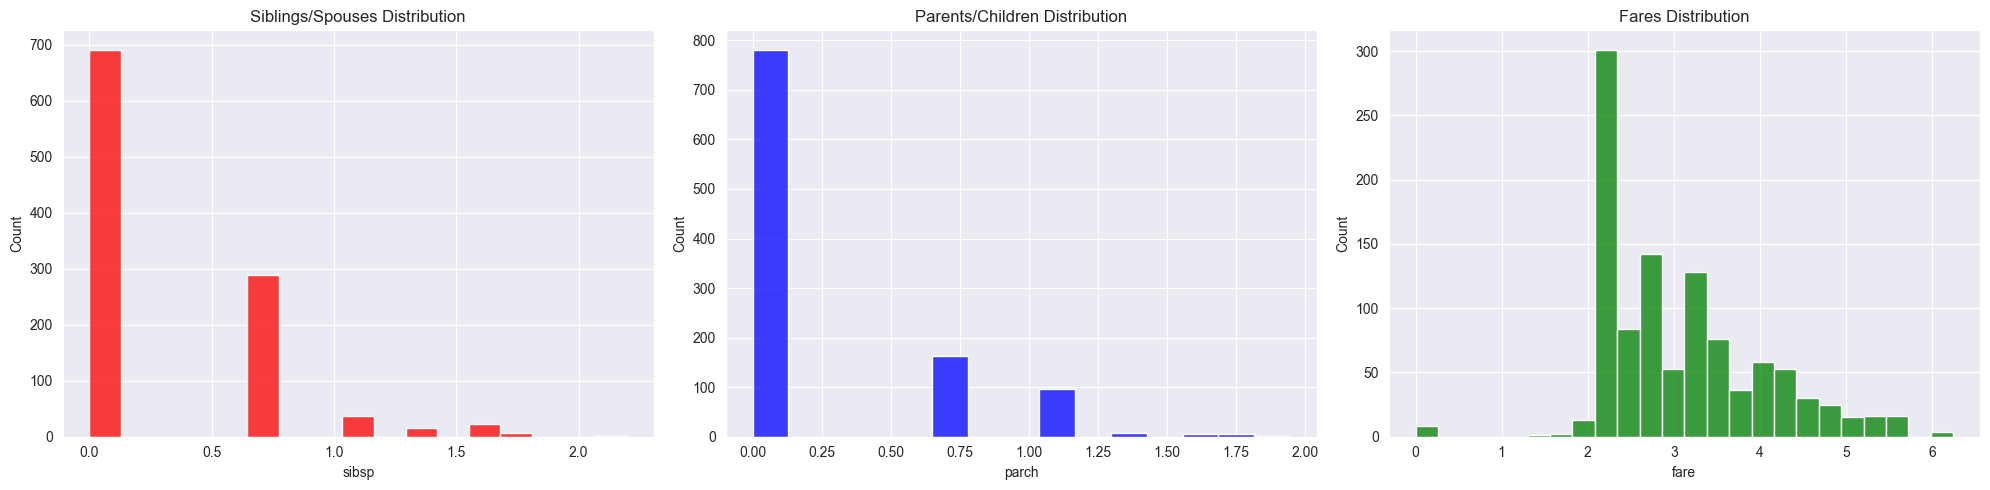

In [8]:
# Apply log transformation to 'fare', 'parch', and 'sibsp' columns
df['fare'] = np.log(df['fare'] + 1)
df['parch'] = np.log(df['parch'] + 1)
df['sibsp'] = np.log(df['sibsp'] + 1)
df['age'] = np.log(df['age'] + 1)

axes = plt.subplots(1, 3, figsize=(20, 5))[1]

# Siblings/Spouses Distribution
sns.histplot(df['sibsp'], ax=axes[0], color='red')
axes[0].set_title('Siblings/Spouses Distribution')

# Parents/Children Distribution
sns.histplot(df['parch'], ax=axes[1], color='blue')
axes[1].set_title('Parents/Children Distribution')

# Fares Distribution
sns.histplot(df['fare'], ax=axes[2], color='green')
axes[2].set_title('Fares Distribution')

plt.tight_layout()
plt.show()

In [9]:
# Scaling features
scaler = MinMaxScaler()
df[['fare', 'parch', 'sibsp', 'pclass', 'age']] = scaler.fit_transform(df[['fare', 'parch', 'sibsp', 'pclass', 'age']])

In [10]:
# Splitting the data back to train and test sets
test_set = df.tail(19).copy()
test_set.drop(["survived"], axis=1, inplace=True)
df = df.iloc[:-19]
test_set.head().style.background_gradient(cmap="turbo")

,pclass,name,age,sibsp,parch,ticket,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
1308,1.000000,"Zimmerman, Mr. Leo",0.765757,0.000000,0.000000,315082,0.349827,False,True,False,False,True
1309,1.000000,"Kelly, Mr. James",0.805457,0.000000,0.000000,330911,0.348997,False,True,False,True,False
1310,1.000000,"Wilkes, Mrs. James (Ellen Needs)",0.876600,0.315465,0.000000,363272,0.333195,True,False,False,False,True
1311,0.500000,"Myles, Mr. Thomas Francis",0.940732,0.000000,0.000000,240276,0.379604,False,True,False,True,False
1312,1.000000,"Wirz, Mr. Albert",0.749487,0.000000,0.000000,315154,0.363449,False,True,False,False,True


In [11]:
# Handling outliers using inter-quartile range
print("Number of rows before:", df.shape[0])
numeric_columns = df.select_dtypes(include='number')

# Calculate the inter-quartile range (IQR)
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create masks for outliers in each feature
lower_outliers = (numeric_columns < lower_bound)
upper_outliers = (numeric_columns > upper_bound)

# Combine the masks to detect outliers in any feature
outliers_mask = lower_outliers | upper_outliers

# Remove outliers from the dataset
df = df[~outliers_mask.any(axis=1)]
print("Number of rows after:", df.shape[0])

Number of rows before: 1042
Number of rows after: 950


In [12]:
df.head().style.background_gradient(cmap="turbo")

,pclass,name,age,sibsp,parch,ticket,fare,survived,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,0.000000,"Allen, Miss. Elisabeth Walton",0.765757,0.000000,0.000000,24160,0.858556,1.000000,True,False,False,False,True
3,0.000000,"Allison, Mr. Hudson Joshua Creighton",0.773490,0.315465,0.564575,113781,0.805569,0.000000,False,True,False,False,True
4,0.000000,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0.732009,0.315465,0.564575,113781,0.805569,0.000000,True,False,False,False,True
5,0.000000,"Anderson, Mr. Harry",0.881463,0.000000,0.000000,19952,0.531333,1.000000,False,True,False,False,True
6,0.000000,"Andrews, Miss. Kornelia Theodosia",0.944446,0.315465,0.000000,13502,0.700044,1.000000,True,False,False,False,True


In [13]:
# Splitting the data into features and target variable
X = df.drop(["survived", "name", "ticket"], axis=1)  # Features
y = df["survived"]  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Naive Bayes
   * Checking dataset for imbalance between labels.
   * Training the model on the training set.
   * Performing cross-validation.
   * Evaluating the model using different metrics and visualizing the results.
   * Predicting survival status of new examples in the test set.

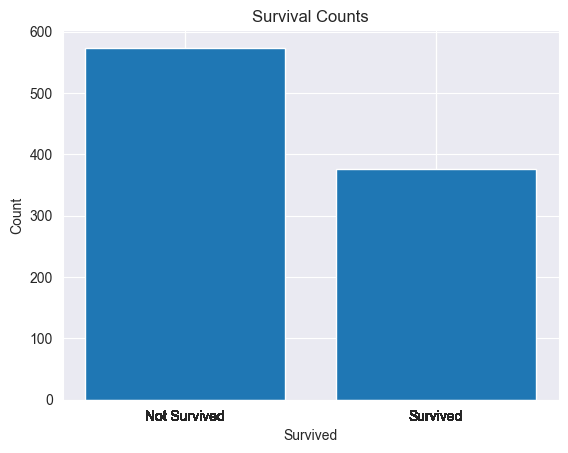

In [14]:
# Check if the dataset is balanced
survived_counts = df['survived'].map({1: 'Survived', 0: 'Not Survived'}).value_counts()
plt.bar(survived_counts.index, survived_counts.values)

plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Survival Counts')
plt.xticks(df['survived'].map({1: 'Survived', 0: 'Not Survived'}))

plt.show()

In [15]:
# Train Naive Bayes Classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(nb_classifier, X, y, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

# Make predictions
y_pred_nb = nb_classifier.predict(X_test)

Cross-validation scores: [0.47368421 0.87894737 0.82105263 0.76842105 0.67368421]
Mean accuracy: 0.723157894736842


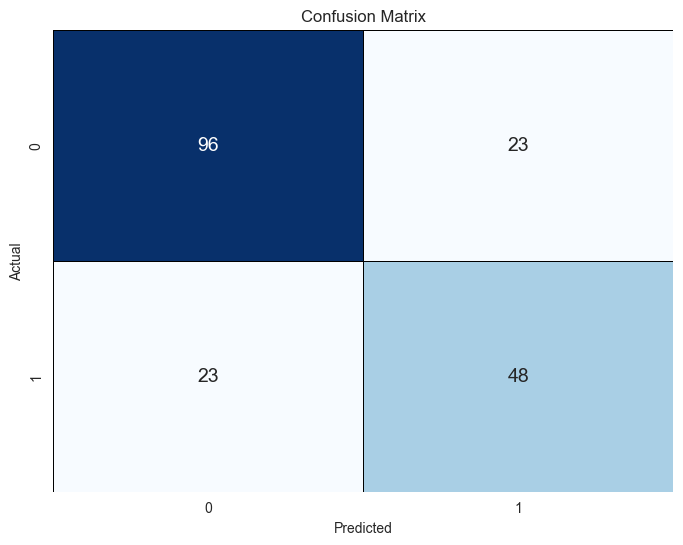


Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       119
         1.0       0.68      0.68      0.68        71

    accuracy                           0.76       190
   macro avg       0.74      0.74      0.74       190
weighted avg       0.76      0.76      0.76       190



In [16]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_nb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"fontsize": 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

In [17]:
# Predicting survival status of new data

test_set['nb_survived'] = nb_classifier.predict(test_set.drop(['name', 'ticket'], axis=1)).astype(int)
test_set[['name', 'nb_survived']].style.background_gradient(cmap="turbo")

,name,nb_survived
1308,"Zimmerman, Mr. Leo",0
1309,"Kelly, Mr. James",0
1310,"Wilkes, Mrs. James (Ellen Needs)",1
1311,"Myles, Mr. Thomas Francis",0
1312,"Wirz, Mr. Albert",0
1313,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1
1314,"Svensson, Mr. Johan Cervin",0
1315,"Connolly, Miss. Kate",0
1316,"Caldwell, Mr. Albert Francis",0
1317,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1


### Support Vector Machine (SVM)
* Set a range of complexity degrees to test.
* Perform a grid search to find the degree that yields the highest accuracy.
* Performing cross-validation.
* Plot a curve to visualize the relation between model degree and accuracy.
* Fit the model on the training set.
* Evaluating the model using different metrics and visualizing the results.
* Predicting survival status of new examples in the test set.

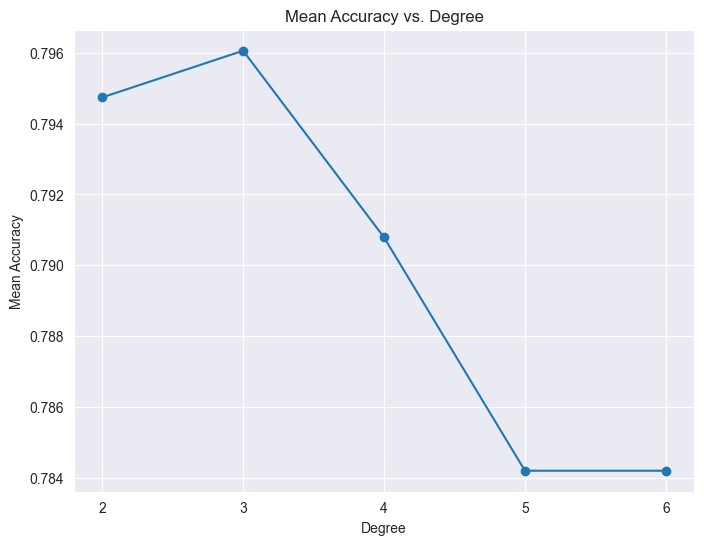

Optimal degree: 3
Cross-validation scores with optimal degree: [0.80263158 0.77631579 0.78947368 0.80263158 0.80921053]
Mean accuracy with optimal degree: 0.7960526315789473


In [18]:
# Define range of degrees to try
degrees = [2, 3, 4, 5, 6]  # Trying degrees from 2 to 6

# Define parameters grid
param_grid = {'degree': degrees}

# Initialize SVM classifier
svm_classifier = SVC(kernel='poly')

# Perform grid search
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the mean cross-validation scores
mean_scores = grid_search.cv_results_['mean_test_score']
mean_scores = mean_scores.reshape(len(degrees), -1)

# Plot curve
plt.figure(figsize=(8, 6))
plt.plot(degrees, mean_scores, marker='o', linestyle='-')
plt.title('Mean Accuracy vs. Degree')
plt.xlabel('Degree')
plt.ylabel('Mean Accuracy')
plt.xticks(degrees)
plt.grid(True)
plt.show()

# Get the best degree
best_degree = grid_search.best_params_['degree']
print("Optimal degree:", best_degree)

# Train SVM classifier with optimal degree
svm_classifier_optimal = SVC(kernel='poly', degree=best_degree)
svm_classifier_optimal.fit(X_train, y_train)

# Perform cross-validation with optimal degree
optimal_cv_scores = cross_val_score(svm_classifier_optimal, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores with optimal degree:", optimal_cv_scores)
print("Mean accuracy with optimal degree:", np.mean(optimal_cv_scores))

# Make predictions
y_pred_svm = svm_classifier_optimal.predict(X_test)

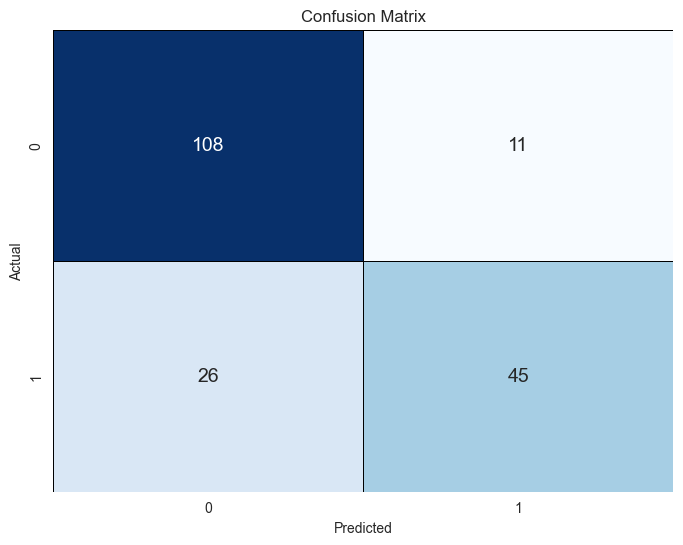


Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.91      0.85       119
         1.0       0.80      0.63      0.71        71

    accuracy                           0.81       190
   macro avg       0.80      0.77      0.78       190
weighted avg       0.81      0.81      0.80       190



In [19]:
# Compute confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"fontsize": 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

In [20]:
test_set['svm_survived'] = svm_classifier_optimal.predict(test_set.drop(['name', 'ticket', 'nb_survived'], axis=1)).astype(int)
test_set[['name', 'nb_survived', 'svm_survived']].style.background_gradient(cmap="turbo")

,name,nb_survived,svm_survived
1308,"Zimmerman, Mr. Leo",0,0
1309,"Kelly, Mr. James",0,0
1310,"Wilkes, Mrs. James (Ellen Needs)",1,1
1311,"Myles, Mr. Thomas Francis",0,0
1312,"Wirz, Mr. Albert",0,0
1313,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1
1314,"Svensson, Mr. Johan Cervin",0,0
1315,"Connolly, Miss. Kate",0,0
1316,"Caldwell, Mr. Albert Francis",0,0
1317,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1,1


### K-Nearest Neighbors (KNN)
* Setting a range of K values to try.
* Plotting the validation curve to visualize the relation between K and the model's accuracy.
* Choosing the optimal value of K.
* Training the model on the training set.
* Performing cross-validation.
* Evaluating the model using different metrics and visualizing the results.
* Predicting survival status of new examples in the test set.

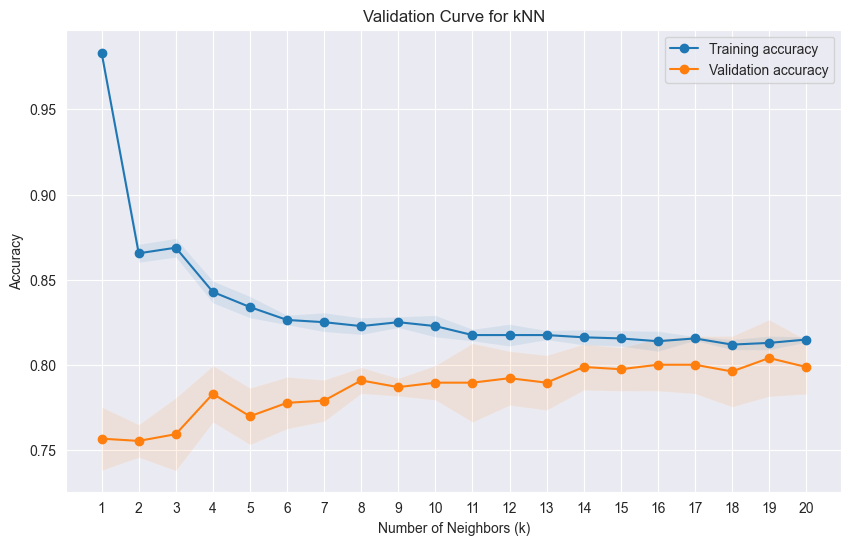

Optimal value of k: 19
Cross-validation scores with optimal k: [0.80921053 0.76973684 0.78947368 0.83552632 0.81578947]
Mean accuracy with optimal k: 0.8039473684210525


In [21]:
# Define range of k values to try
k_values = range(1, 21)

# Train KNN classifier
knn_classifier = KNeighborsClassifier()

# Compute validation curve
train_scores, test_scores = validation_curve(
    knn_classifier, X_train, y_train, param_name="n_neighbors", param_range=k_values,
    cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean scores and standard deviations across CV folds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_mean, marker='o', label='Training accuracy')
plt.fill_between(k_values, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(k_values, test_mean, marker='o', label='Validation accuracy')
plt.fill_between(k_values, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Validation Curve for kNN')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

# Find the optimal value of k (elbow point)
optimal_k = k_values[np.argmax(test_mean)]
print("Optimal value of k:", optimal_k)

# Train KNN classifier with optimal k
knn_classifier_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_classifier_optimal.fit(X_train, y_train)

# Perform cross-validation with optimal k
optimal_cv_scores = cross_val_score(knn_classifier_optimal, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores with optimal k:", optimal_cv_scores)
print("Mean accuracy with optimal k:", np.mean(optimal_cv_scores))

# Make predictions
y_pred_knn = knn_classifier_optimal.predict(X_test)


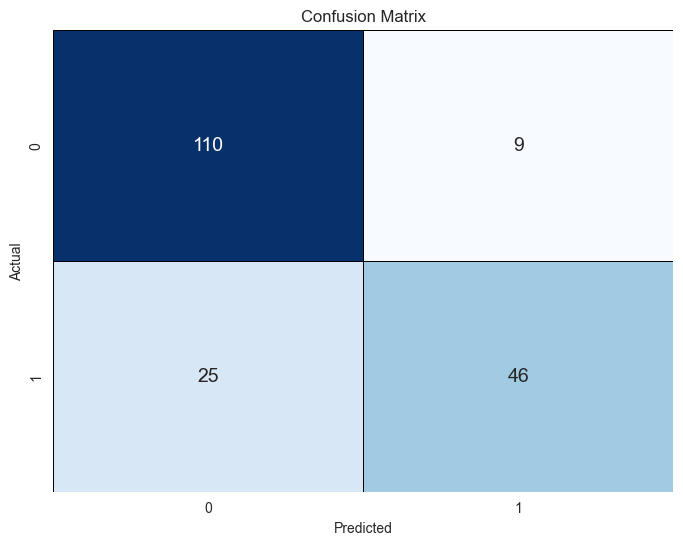


Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.92      0.87       119
         1.0       0.84      0.65      0.73        71

    accuracy                           0.82       190
   macro avg       0.83      0.79      0.80       190
weighted avg       0.82      0.82      0.82       190



In [22]:
# Compute confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"fontsize": 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

In [23]:
# Predicting survival status of new data
test_set['knn_survived'] = knn_classifier_optimal.predict(test_set.drop(['name', 'ticket', 'nb_survived', 'svm_survived'], axis=1)).astype(int)
test_set[['name', 'nb_survived', 'svm_survived', 'knn_survived']].style.background_gradient(cmap="turbo")

,name,nb_survived,svm_survived,knn_survived
1308,"Zimmerman, Mr. Leo",0,0,0
1309,"Kelly, Mr. James",0,0,0
1310,"Wilkes, Mrs. James (Ellen Needs)",1,1,0
1311,"Myles, Mr. Thomas Francis",0,0,0
1312,"Wirz, Mr. Albert",0,0,0
1313,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1,1
1314,"Svensson, Mr. Johan Cervin",0,0,0
1315,"Connolly, Miss. Kate",0,0,0
1316,"Caldwell, Mr. Albert Francis",0,0,0
1317,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1,1,1


### Artificial Neural Network (ANN)
* Converting data to tensor format.
* Dividing the data into batches for cross-validation.
* Defining network architecture with the appropriate activations.
* Choosing the appropriate loss function and optimization algorithm.
* Training the model on the training set.
* Evaluating the model using different metrics and visualizing the results.
* Predicting survival status of new examples in the test set.

In [24]:
# Convert NumPy arrays to TensorFlow tensors
X_train_tensor = tf.constant(X_train, dtype=tf.float32)
X_test_tensor = tf.constant(X_test, dtype=tf.float32)
y_train_tensor = tf.constant(y_train, dtype=tf.float32)
y_test_tensor = tf.constant(y_test, dtype=tf.float32)
test_set_tensor = tf.constant(test_set.drop(['name', 'ticket', 'nb_survived', 'svm_survived', 'knn_survived'], axis=1), dtype=tf.float32)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_tensor))


# Shuffle and batch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Define the neural network architecture
ann_classifier = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
ann_classifier.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Train the model
ann_classifier.fit(train_dataset, epochs=20, validation_data=test_dataset)

# Evaluate the model
test_loss, test_accuracy = ann_classifier.evaluate(test_dataset)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_probabilities = ann_classifier.predict(test_dataset)
y_pred_ann = (y_pred_probabilities > 0.5).astype(int)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5155 - loss: 0.6969 - val_accuracy: 0.7947 - val_loss: 0.5928
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8071 - loss: 0.5773 - val_accuracy: 0.8000 - val_loss: 0.5136
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7930 - loss: 0.5080 - val_accuracy: 0.7895 - val_loss: 0.4786
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7937 - loss: 0.4546 - val_accuracy: 0.7895 - val_loss: 0.4740
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8023 - loss: 0.4529 - val_accuracy: 0.8000 - val_loss: 0.4685
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8008 - loss: 0.4327 - val_accuracy: 0.8000 - val_loss: 0.4704
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8158 - loss: 0.4340 - val_accuracy: 0.8000 - val_loss: 0.4645
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8056 - loss: 0.4506 - val_accuracy: 0.8053 - val_loss

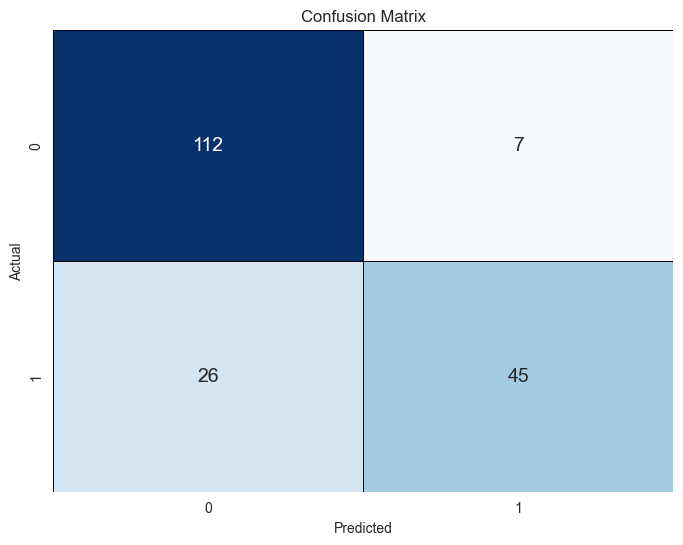


Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.94      0.87       119
         1.0       0.87      0.63      0.73        71

    accuracy                           0.83       190
   macro avg       0.84      0.79      0.80       190
weighted avg       0.83      0.83      0.82       190



In [25]:
# Convert probabilities to binary predictions
y_pred_ann = (y_pred_ann > 0.5).astype(int)

# Compute confusion matrix
conf_matrix_ann = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ann, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"fontsize": 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_ann))

In [26]:
# Predicting survival status of new data
ann_survived = ann_classifier.predict(test_set_tensor)
test_set['ann_survived'] = (ann_survived > 0.5).astype(int)
test_set[['name', 'nb_survived', 'svm_survived', 'knn_survived', 'ann_survived']].style.background_gradient(cmap="turbo")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


,name,nb_survived,svm_survived,knn_survived,ann_survived
1308,"Zimmerman, Mr. Leo",0,0,0,0
1309,"Kelly, Mr. James",0,0,0,0
1310,"Wilkes, Mrs. James (Ellen Needs)",1,1,0,0
1311,"Myles, Mr. Thomas Francis",0,0,0,0
1312,"Wirz, Mr. Albert",0,0,0,0
1313,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1,1,0
1314,"Svensson, Mr. Johan Cervin",0,0,0,0
1315,"Connolly, Miss. Kate",0,0,0,0
1316,"Caldwell, Mr. Albert Francis",0,0,0,0
1317,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1,1,1,1


In [27]:
# Comparing models' performance
performance = {
    "Model" : ["Naive Bayes", "SVM", "KNN", "ANN"],
    "Accuracy" : [accuracy_score(y_test, y_pred_nb)*100, accuracy_score(y_test, y_pred_svm)*100, accuracy_score(y_test, y_pred_knn)*100, accuracy_score(y_test, y_pred_ann)*100],
    "Precision": [precision_score(y_test, y_pred_nb)*100, precision_score(y_test, y_pred_svm)*100, precision_score(y_test, y_pred_knn)*100, precision_score(y_test, y_pred_ann)*100],
    "Recall": [recall_score(y_test, y_pred_nb)*100, recall_score(y_test, y_pred_svm)*100, recall_score(y_test, y_pred_knn)*100, recall_score(y_test, y_pred_ann)*100],
    "F1-score": [f1_score(y_test, y_pred_nb)*100, f1_score(y_test, y_pred_svm)*100, f1_score(y_test, y_pred_knn)*100, f1_score(y_test, y_pred_ann)*100]
}
pd.DataFrame(performance).round(2).style.background_gradient(cmap="turbo")

,Model,Accuracy,Precision,Recall,F1-score
0,Naive Bayes,75.790000,67.610000,67.610000,67.610000
1,SVM,80.530000,80.360000,63.380000,70.870000
2,KNN,82.110000,83.640000,64.790000,73.020000
3,ANN,82.630000,86.540000,63.380000,73.170000
